In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go

In [5]:
ticker = "SBER.ME"
start_date = "2020-01-01"
end_date = "2024-12-31"

data = yf.download(ticker, start=start_date, end=end_date)
data[:3]

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SBER.ME,SBER.ME,SBER.ME,SBER.ME,SBER.ME
Date,,,,,
2020-01-03,220.372696,223.129517,219.249225,221.228265,35851840
2020-01-06,219.422073,219.422073,217.261557,219.119609,22348300
2020-01-08,223.959152,223.959152,218.670212,219.136891,40817242


In [6]:
# Расчет логарифмических доходностей
data["LogReturns"] = np.log(data["Close"] / data["Close"].shift(1))
log_returns = data["LogReturns"].dropna()

print("Первые 5 лог-доходностей:")
print(log_returns.head())
print(f"\nВсего наблюдений: {len(log_returns)}")
print(f"Среднее: {log_returns.mean():.6f}")
print(f"Стандартное отклонение: {log_returns.std():.6f}")
print(f"Эксцесс: {log_returns.kurtosis():.6f}") # Положительный эксцесс -> тяжелые хвосты
print(f"Асимметрия: {log_returns.skew():.6f}")

Первые 5 лог-доходностей:
Date
2020-01-06   -0.004323
2020-01-08    0.020467
2020-01-09   -0.004486
2020-01-10    0.000775
2020-01-13    0.016174
Name: LogReturns, dtype: float64

Всего наблюдений: 581
Среднее: -0.000968
Стандартное отклонение: 0.035969
Эксцесс: 161.439841
Асимметрия: -9.275583


In [8]:
# 2. Оценка параметров распределений методом MLE
# 2.1 Нормальное распределение
norm_params = stats.norm.fit(log_returns)
norm_mu, norm_sigma = norm_params
print(f"Параметры нормального распределения (MLE): mu = {norm_mu:.6f}, sigma = {norm_sigma:.6f}")

Параметры нормального распределения (MLE): mu = -0.000968, sigma = 0.035938


In [9]:
# 2.2 Распределение Стьюдента
t_params = stats.t.fit(log_returns)
t_df, t_loc, t_scale = t_params # df - степени свободы, loc - сдвиг, scale - масштаб
print(f"Параметры распределения Стьюдента (MLE): df = {t_df:.6f}, loc = {t_loc:.6f}, scale = {t_scale:.6f}")

Параметры распределения Стьюдента (MLE): df = 2.184372, loc = 0.000478, scale = 0.013192


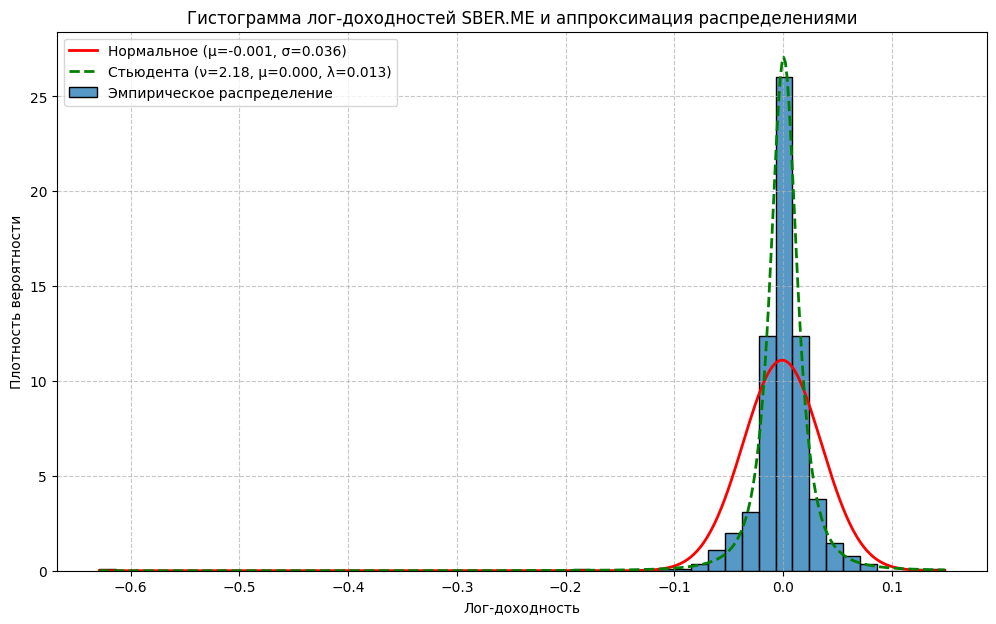

In [10]:
# 3. Визуализация результатов
plt.figure(figsize=(12, 7))
sns.histplot(log_returns, bins=50, kde=False, stat="density", label="Эмпирическое распределение")

# PDF нормального распределения
x = np.linspace(log_returns.min(), log_returns.max(), 500)
pdf_norm = stats.norm.pdf(x, loc=norm_mu, scale=norm_sigma)
plt.plot(x, pdf_norm, "r-", lw=2, label=f"Нормальное (μ={norm_mu:.3f}, σ={norm_sigma:.3f})")

# PDF распределения Стьюдента
pdf_t = stats.t.pdf(x, df=t_df, loc=t_loc, scale=t_scale)
plt.plot(x, pdf_t, "g--", lw=2, label=f"Стьюдента (ν={t_df:.2f}, μ={t_loc:.3f}, λ={t_scale:.3f})")

plt.title(f"Гистограмма лог-доходностей {ticker} и аппроксимация распределениями")
plt.xlabel("Лог-доходность")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [11]:
# Q-Q графики
# Нормальное распределение
fig_qq_norm = go.Figure()
qq_norm_data = stats.probplot(log_returns, dist=stats.norm, sparams=(norm_mu, norm_sigma), plot=None)
fig_qq_norm.add_trace(go.Scatter(x=qq_norm_data[0][0], y=qq_norm_data[0][1], mode='markers', name='Эмпирические квантили'))
fig_qq_norm.add_trace(go.Scatter(x=qq_norm_data[0][0], y=qq_norm_data[1][0]*qq_norm_data[0][0] + qq_norm_data[1][1], mode='lines', name='Теоретическая линия')) # y = slope*x + intercept
fig_qq_norm.update_layout(title=f'Q-Q Plot: {ticker} vs Нормальное распределение',
                          xaxis_title='Теоретические квантили (Нормальное)',
                          yaxis_title='Квантили выборки')
fig_qq_norm.show()


# Распределение Стьюдента
fig_qq_t = go.Figure()
# Для stats.probplot с t-распределением, sparams должны быть (df, loc, scale)
# Однако, stats.probplot ожидает стандартное t-распределение, если не указать sparams.
# Чтобы корректно сравнить с подогнанным t-распределением, лучше использовать его CDF.
# Или, если используем sparams, то они должны быть (df, loc, scale)
# qq_t_data = stats.probplot(log_returns, dist=stats.t, sparams=(t_df, t_loc, t_scale), plot=None)
# Более надежный способ для произвольного подогнанного распределения:
sorted_returns = np.sort(log_returns)
theoretical_quantiles_t = stats.t.ppf(np.linspace(0.001, 0.999, len(sorted_returns)), df=t_df, loc=t_loc, scale=t_scale)

fig_qq_t.add_trace(go.Scatter(x=theoretical_quantiles_t, y=sorted_returns, mode='markers', name='Эмпирические квантили'))
# Добавим линию y=x для идеального совпадения
min_val = min(np.min(theoretical_quantiles_t), np.min(sorted_returns))
max_val = max(np.max(theoretical_quantiles_t), np.max(sorted_returns))
fig_qq_t.add_trace(go.Scatter(x=[min_val, max_val], y=[min_val, max_val], mode='lines', name='y=x (Идеальное совпадение)', line=dict(dash='dash')))

fig_qq_t.update_layout(title=f'Q-Q Plot: {ticker} vs Распределение Стьюдента (подобранное)',
                       xaxis_title='Теоретические квантили (Стьюдента)',
                       yaxis_title='Квантили выборки')
fig_qq_t.show()

In [13]:
# 4. Статистические тесты
# Критерий Колмогорова-Смирнова
# H0: выборка распределена согласно указанному закону
# Для нормального распределения
ks_stat_norm, ks_pvalue_norm = stats.kstest(log_returns, 'norm', args=(norm_mu, norm_sigma))
print(f"Тест Колмогорова-Смирнова для нормального распределения:")
print(f"Статистика = {ks_stat_norm:.4f}, p-value = {ks_pvalue_norm:.4f}")

# Для распределения Стьюдента
# kstest ожидает функцию CDF или имя распределения из scipy.stats
# Если используем имя, то параметры передаются через args
ks_stat_t, ks_pvalue_t = stats.kstest(log_returns, 't', args=(t_df, t_loc, t_scale))
print(f"\nТест Колмогорова-Смирнова для распределения Стьюдента:")
print(f"Статистика = {ks_stat_t:.4f}, p-value = {ks_pvalue_t:.4f}")

# Вывод: если p-value < 0.05, то гипотеза H0 отвергается.
# Чем больше p-value, тем лучше согласие.
# Чем меньше статистика D, тем лучше согласие.

Тест Колмогорова-Смирнова для нормального распределения:
Статистика = 0.1723, p-value = 0.0000

Тест Колмогорова-Смирнова для распределения Стьюдента:
Статистика = 0.0359, p-value = 0.4333


In [15]:
# 5. Формирование таблиц с результатами
results_summary = pd.DataFrame({
    "Распределение": ["Нормальное", "Стьюдента"],
    "Параметры (MLE)": [
        f"μ={norm_mu:.4f}, σ={norm_sigma:.4f}",
        f"ν={t_df:.2f}, μ={t_loc:.4f}, λ={t_scale:.4f}"
    ],
    "KS Статистика": [ks_stat_norm, ks_stat_t],
    "KS p-value": [ks_pvalue_norm, ks_pvalue_t]
})
print("--- Сводная таблица результатов ---")
print(results_summary.to_string(index=False))

--- Сводная таблица результатов ---
Распределение            Параметры (MLE)  KS Статистика   KS p-value
   Нормальное        μ=-0.0010, σ=0.0359       0.172258 1.519796e-15
    Стьюдента ν=2.18, μ=0.0005, λ=0.0132       0.035870 4.333411e-01
